# VLSE Curves and Datapoint Generation for MD Simulation

Importing Modules

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
from matplotlib.widgets import SpanSelector
import math
import scipy

User options

In [72]:
include_2019_data = True # Includes 2019 data in graphs, no effect on curve fits
triple_point_tolerance = 1*10**(-10) # Solver tolerence for finding triple point
desired_number_of_sobol_points = 10000 # The actual number of sobol points is this number rounded to the nearest 2^n where n -> intiger
max_temp = 10 

Instantiating data

In [73]:
vle_temp_2019_data = np.array([0.4,0.41,0.42,0.43,0.44])
inverse_gas_density_2019_data = np.array([35.40806914,28.16798258,21.91249159,16.245217,11.06553708])
inverse_liq_density_2019_data = np.array([1.331229281,1.361101621,1.39302346,1.436343071,1.480891538])
vle_density_gas_2019_data = np.reciprocal(inverse_gas_density_2019_data)
vle_density_liq_2019_data = np.reciprocal(inverse_liq_density_2019_data)

density_f = np.array([0.786,0.801,0.829,0.856])
density_s = np.array([0.855,0.870,0.880,0.903])
T_sf = np.array([0.45,0.55,0.70,1])

critical_point_density = np.array([0.366])
critical_point_temperature = np.array([0.522])

T_gl = np.array([0.450,0.460,0.470,0.480,0.490,0.495,0.500,0.505,0.515])
density_gas = np.array([0.030, 0.036, 0.05, 0.053, 0.064, 0.07, 0.09, 0.09, 0.28])
density_liq = np.array([0.722,0.72,0.70,0.68,0.65,0.65,0.65,0.64,0.43])

T_vl = np.array([0.415,0.425,0.435,0.445,0.450,0.455,0.460,0.465,0.468])
density_gas2 = np.array([0.0163,0.0173,0.0235,0.0274,0.0285,0.0339,0.0406,0.0473,0.0420])
density_liq2 = np.array([0.763,0.757,0.738,0.725,0.712,0.706,0.698,0.695,0.603])

liq_vle_density = np.concatenate((critical_point_density,density_liq,density_liq2))
liq_vle_temp = np.concatenate((critical_point_temperature,T_gl,T_vl))
gas_vle_density = np.concatenate((density_gas2,density_gas,critical_point_density))
gas_vle_temperature = np.concatenate((T_vl,T_gl,critical_point_temperature))

vle_liq_df = pd.DataFrame({
    'Densities' : liq_vle_density,
    'Temperatures' : liq_vle_temp})
vle_liq_df_sorted = vle_liq_df.sort_values(by=['Densities'])
vle_liq_df_sorted
vle_liq_den = vle_liq_df_sorted['Densities'].to_numpy()
vle_liq_tem = vle_liq_df_sorted['Temperatures'].to_numpy()

vle_gas_df = pd.DataFrame({
    'Densities' : gas_vle_density,
    'Temperatures' : gas_vle_temperature})
vle_gas_df_sorted = vle_gas_df.sort_values(by=['Densities'])
vle_gas_den = vle_gas_df_sorted['Densities'].to_numpy()
vle_gas_tem = vle_gas_df_sorted['Temperatures'].to_numpy()

vle_densities = np.concatenate([vle_gas_den,vle_liq_den])
vle_temperatures = np.concatenate([vle_gas_tem,vle_liq_tem])

liquid_density_range = np.linspace(min(vle_liq_den),min(density_f),100)
gas_density_range = np.linspace(min(gas_vle_density),max(gas_vle_density),100)
solid_density_range = np.linspace(max(vle_liq_den),max(density_f),10000)

Fitting curves

In [74]:
def liquid_curve(x,a,b,c):
    return a*np.arctan(b*x-c)
liquid_curve_parameters,pcov2 = curve_fit(liquid_curve,vle_liq_den,vle_liq_tem,maxfev = 100000000)

def vapour_curve(x,a,b,c,d):
    return a*np.arctan(b*x-c)+d
vapour_curve_parameters,pcov1 = curve_fit(vapour_curve,vle_gas_den,vle_gas_tem,maxfev = 100000000)

def solid_curve(x,a,b,c):
    return a*np.exp(b*x)+c
solid_curve_parameters,pcov4 = curve_fit(solid_curve,density_f,T_sf,maxfev = 100000000)

Finding triple point

In [75]:
def difference_between_solid_liquid(x,fitted_solid_curve_params,fitted_liquid_curve_params):
    '''
    Calculates the difference between the temperature of the solid phase and liquid phase at a given denisity.
    When fsolve is used on this function finds the point where the liquid curve and solid curve intersect
    '''
    return solid_curve(x,*fitted_solid_curve_params)-liquid_curve(x,*fitted_liquid_curve_params)

density_triple_point = scipy.optimize.fsolve(difference_between_solid_liquid,x0 = 0.768,xtol=triple_point_tolerance,args=(solid_curve_parameters,liquid_curve_parameters))
temperature_triple_point = solid_curve(density_triple_point,*solid_curve_parameters)

# Plotting curves

Plotting VLSE

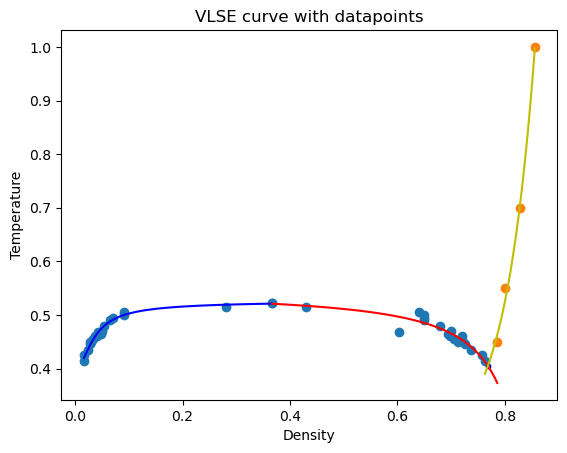

In [76]:
semi_final_fig, plots = plt.subplots()
plots.plot(gas_density_range,vapour_curve(gas_density_range,*vapour_curve_parameters),'b')
plots.plot(liquid_density_range,liquid_curve(liquid_density_range,*liquid_curve_parameters),'r')
plots.plot(solid_density_range,solid_curve(solid_density_range,*solid_curve_parameters),'y')
plots.scatter(vle_densities,vle_temperatures)
plots.scatter(density_f,T_sf)
plots.scatter(density_triple_point,temperature_triple_point,marker = 'o',edgecolor='b',s=10)
plt.title("VLSE curve with datapoints")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

Plotting solid phase only

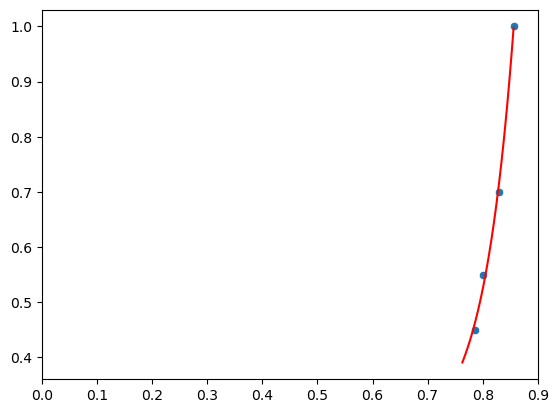

In [77]:
plt.plot(solid_density_range,solid_curve(solid_density_range,*solid_curve_parameters),'r')
sns.scatterplot(x=density_f,y=T_sf)
plt.xlim(0.0,0.9)
plt.show()

Plotting liquid phase only

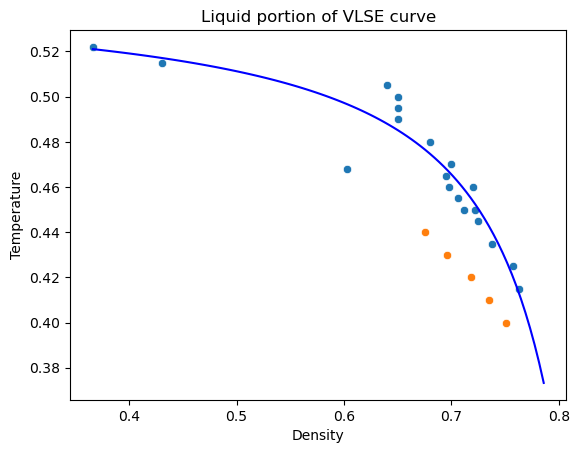

In [78]:
plt.plot(liquid_density_range,liquid_curve(liquid_density_range,*liquid_curve_parameters),'b')
sns.scatterplot(x=vle_liq_den,y=vle_liq_tem)
if include_2019_data == True:
    sns.scatterplot(x=vle_density_liq_2019_data,y=vle_temp_2019_data)
plt.title("Liquid portion of VLSE curve")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

Plotting vapour phase only

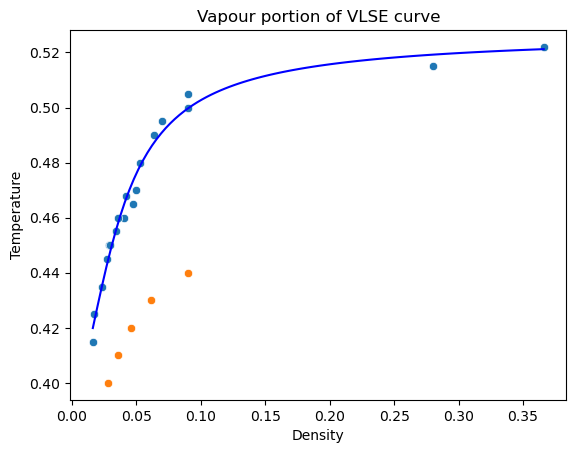

In [79]:
final_fig, phase_plot = plt.subplots()
phase_plot.plot(gas_density_range,vapour_curve(gas_density_range,*vapour_curve_parameters),'b')
sns.scatterplot(x = gas_vle_density,y=gas_vle_temperature)
if include_2019_data == True:
    sns.scatterplot(x=vle_density_gas_2019_data,y=vle_temp_2019_data)
plt.title("Vapour portion of VLSE curve")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

# Datapoint Generation

0       1.682919
1       1.169111
2       2.116100
3       0.112993
4       2.363635
          ...   
8187    0.467805
8188    2.043082
8189    0.197254
8190    1.589376
8191    1.214345
Name: scaled_T, Length: 8192, dtype: float64


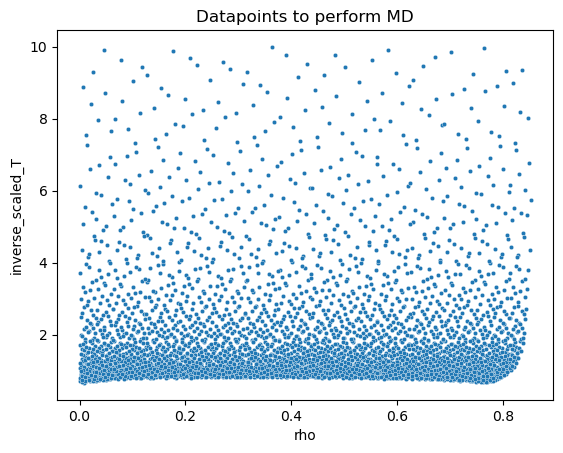

      index       rho  inverse_scaled_T
0         0  0.153796          8.850124
1         1  0.624913          1.966948
2         2  0.413628          1.023316
3         3  0.099842          0.908519
4         4  0.629550          1.418127
...     ...       ...               ...
3425   3425  0.540855          0.943064
3426   3426  0.486034          3.374739
3427   3427  0.046882          2.137643
3428   3428  0.705644          5.069611
3429   3429  0.260694          0.823489

[3430 rows x 3 columns]


In [103]:
def num_of_sobol_points(number_of_points:int):
    """
    Rounds the number of points you input to the nearest number required to be input to the sobol sequence
    i.e.Rounds to the nearest 2^n where n is an int
    """
    exponent_of_two_to_get_required_number_of_points = math.log(number_of_points)/math.log(2)
    rounded_exponent = round(exponent_of_two_to_get_required_number_of_points,0)
    number_of_sobol_points = 2**rounded_exponent
    return int(number_of_sobol_points)

dimension = 2
actual_number_of_points_to_generate = num_of_sobol_points(desired_number_of_sobol_points)
sobol_sequence = scipy.stats.qmc.Sobol(dimension) 
sobol_values = sobol_sequence.random(actual_number_of_points_to_generate)

critical_density = float(critical_point_density)
triple_point_density = float(density_triple_point)

sobol_df = pd.DataFrame(sobol_values)
sobol_df.columns = ['rho','T']
sobol_df['vle_curve_value_at_rho_of_sobol_point'] = np.where(sobol_df["rho"]<critical_density,vapour_curve(sobol_df["rho"],*vapour_curve_parameters),liquid_curve(sobol_df["rho"],*liquid_curve_parameters)) # If the density of the point is less than the critical point density, use vapour equation, if not use the liquid equation
sobol_df['vle_curve_value_at_rho_of_sobol_point'] = np.where(sobol_df["rho"]>triple_point_density,solid_curve(sobol_df["rho"],*solid_curve_parameters),sobol_df['vle_curve_value_at_rho_of_sobol_point']) # If the density of the point is greater then the triple point density, use the SLE curve , if not just keep the VLE curve value
sobol_df['T_greater_than_VLE_curve'] = sobol_df["T"]>sobol_df["vle_curve_value_at_rho_of_sobol_point"] # If the temperature of the sobol point less greater than the value at the SLE-VLE curve at that density , then  True, else false

# print(sobol_df[sobol_df['T_greater_than_VLE_curve']]) # Print the dataframe where only the T_greater_thabn_VLE_curve is True
min_temp = temperature_triple_point
sobol_df['scaled_T'] = (sobol_df['T'])*(1/max_temp-1/min_temp)+1/min_temp
sobol_df['inverse_scaled_T'] = 1/sobol_df['scaled_T']
print(sobol_df['scaled_T'])
plt.clf() # clear any plots
inverse_scaled_t_sobol_df = sobol_df[['rho','inverse_scaled_T']]
t_greater_than_curve_inverse_scaled_t_sobol_df = inverse_scaled_t_sobol_df[sobol_df['T_greater_than_VLE_curve']]
sns.scatterplot(data = t_greater_than_curve_inverse_scaled_t_sobol_df, x='rho',y = 'inverse_scaled_T',s=10).set(title = "Datapoints to perform MD") # Plot the points where only the T for the sobol point is greater than the value for T on the curve
plt.show()
t_greater_than_curve_inverse_scaled_t_sobol_df.reset_index(drop=True, inplace=True)
t_greater_than_curve_inverse_scaled_t_sobol_df.insert(0,"index",t_greater_than_curve_inverse_scaled_t_sobol_df.index)
print(t_greater_than_curve_inverse_scaled_t_sobol_df
# Try T at least 5, 10 is upper bound, Isotherms, do long run sim, check when it equilibrates , 2-3 x equil time, num timesteps foerm old papers, num particles, timestep from prev' papers
np.savetxt(r'C:\Users\Daniel.000\Documents\np.txt', t_greater_than_curve_inverse_scaled_t_sobol_df.values,fmt="%i %f %f")

In [117]:
nvt_path = r"C:\Users\Daniel.000\nvtave.lammps"
nvt_data = pd.read_csv(nvt_path,delimiter = " ",names =["TimeStep", "v_TENE", "v_TEMP", "v_PRES", "v_DENS", "v_nMolecule", "v_KENE", "v_PENE", "v_ENTH", "v_VOL"] )
sns.scatterplot(data = nvt_data,x="TimeStep",y = "v_PENE")

,TimeStep,v_TENE,v_TEMP,v_PRES,v_DENS,v_nMolecule,v_KENE,v_PENE,v_ENTH,v_VOL
0,0,0.973892,2.12039,1.85412,0.5,2048,2.11936,-1.14546,4.68213,4096
1,1000,0.856636,1.99761,1.89161,0.5,2048,1.99663,-1.14000,4.63986,4096
2,2000,0.835898,1.97091,1.83813,0.5,2048,1.96995,-1.13405,4.51216,4096
3,3000,0.817509,1.99052,1.71846,0.5,2048,1.98954,-1.17204,4.25443,4096
4,4000,0.947988,2.05409,1.93543,0.5,2048,2.05309,-1.10510,4.81886,4096
...,...,...,...,...,...,...,...,...,...,...
1996,1996000,0.846499,1.96458,1.90521,0.5,2048,1.96362,-1.11712,4.65692,4096
1997,1997000,0.759993,1.92031,1.74251,0.5,2048,1.91938,-1.15938,4.24500,4096
1998,1998000,0.897653,2.00306,1.98013,0.5,2048,2.00209,-1.10443,4.85791,4096
1999,1999000,0.889111,2.02834,1.86230,0.5,2048,2.02735,-1.13824,4.61372,4096
